# Выполнил:
# Радайкин Артём, ПМ20-4 

## Загружаем данные

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import patsy as pt
import sklearn.linear_model as lm
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

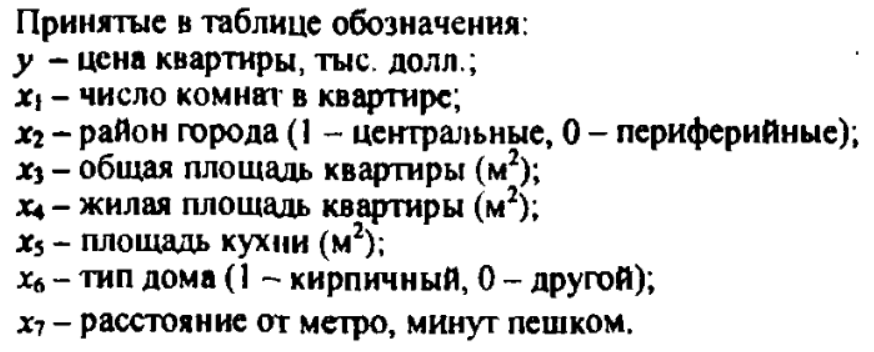

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Эконометрика /29.csv', sep=';', decimal=',')
df.head(5)

,№,Y,X1,X2,X3,X4,X5,X6,X7
0,1.0,13.0,1.0,1.0,37.0,21.5,6.5,0.0,20.0
1,2.0,16.5,1.0,1.0,60.0,27.0,22.4,0.0,10.0
2,3.0,17.0,1.0,1.0,60.0,30.0,15.0,0.0,10.0
3,4.0,15.0,1.0,1.0,53.0,26.2,13.0,0.0,15.0
4,5.0,14.2,1.0,1.0,35.0,19.0,9.0,0.0,8.0


In [ ]:
df = df.drop('№',axis=1)

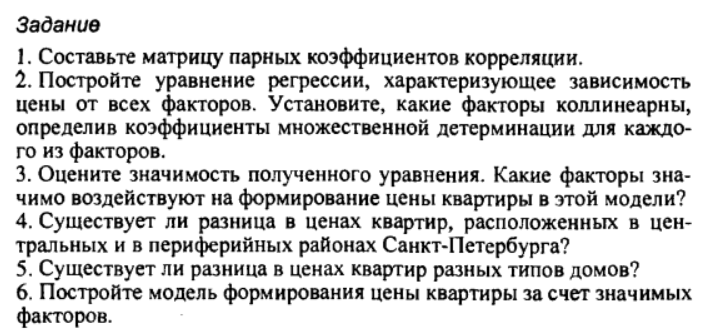

In [ ]:
fig = px.imshow(df.corr(), text_auto = True , height = 800, width = 800 , template = 'ggplot2' , aspect = 'auto' , title = 'Парная корреляция между всеми численными столбцами')
fig.update_layout(title_x = 0.5)
fig.show()

In [ ]:
X = df.drop('Y', axis=1)

In [ ]:
import numpy as np
import pandas as pd
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif_(X, thresh=5.0):
    # df_vif = pd.DataFrame(columns=X.columns)
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    k = 0
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))
        k += 1
        if k == 1:
            df_vif.loc[0] = vif

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return X[[i for i in variables]]

X2 = calculate_vif_(X,5) # Actually running the function

7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Tue Dec 27 11:34:05 2022 dropping 'X3' at index: 2
6
Tue Dec 27 11:34:05 2022 dropping 'X4' at index: 2
5
Remaining variables:
[['X1', 'X2', 'X5', 'X6', 'X7']]


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


### Определим Variance inflation factor для каждого фактора:

In [ ]:
for i in range(1, 8):
  str_x = ' + '.join([f'X{j}' for j in range(1, 8) if j != i])
  pr_res = sm.OLS.from_formula(f'X{i} ~ {str_x}', data = df)
  r_sq = pr_res.fit().rsquared
  print(f'R^2 (зависимая переменная - x{i}): {r_sq}, VIF-статистика: {1 / (1 - r_sq)}')

R^2 (зависимая переменная - x1): 0.7497654798977451, VIF-статистика: 3.9962511950444077
R^2 (зависимая переменная - x2): 0.10902505181196454, VIF-статистика: 1.1223660126849666
R^2 (зависимая переменная - x3): 0.9826883412888272, VIF-статистика: 57.76453987939403
R^2 (зависимая переменная - x4): 0.9783281755933809, VIF-статистика: 46.14286186697677
R^2 (зависимая переменная - x5): 0.7852174731701901, VIF-статистика: 4.655872219961279
R^2 (зависимая переменная - x6): 0.14619159073090782, VIF-статистика: 1.1712229455037295
R^2 (зависимая переменная - x7): 0.09655310814058449, VIF-статистика: 1.1068719246372802


### Таким образом для модели оставляем только 'X1', 'X2', 'X5', 'X6', 'X7'

In [ ]:
" + ".join(X2.columns)

'X1 + X2 + X5 + X6 + X7'

In [ ]:
model = sm.OLS.from_formula("Y ~ X1 + C(X2) + X5 + C(X6) + X7 ",
                            data=df)
result = model.fit()
print(result.params)

Intercept       1.227790
C(X2)[T.1.0]   -0.373404
C(X6)[T.1.0]    0.154287
X1              6.459513
X5              0.833605
X7             -0.181080
dtype: float64


In [ ]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     24.16
Date:                Tue, 27 Dec 2022   Prob (F-statistic):           4.84e-14
Time:                        11:34:05   Log-Likelihood:                -258.58
No. Observations:                  76   AIC:                             529.2
Df Residuals:                      70   BIC:                             543.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.2278      3.316      0.370   

## Новая модель только со значимыми факторами:

In [ ]:
model2 = sm.OLS.from_formula("Y ~ 0 + X1 + X5 ",
                            data=df)
result2 = model2.fit()
print(result2.params)

X1    6.489378
X5    0.765866
dtype: float64


In [ ]:
print(result2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              493.8
Date:                Tue, 27 Dec 2022   Prob (F-statistic):                    1.58e-43
Time:                        11:34:06   Log-Likelihood:                         -259.35
No. Observations:                  76   AIC:                                      522.7
Df Residuals:                      74   BIC:                                      527.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Оценка качества модели:

In [ ]:
R_2 =  0.930
R_adj = 0.928
n = 76
k = 2

A_mean = (1/n) * (sum(abs((result2.resid) / df['Y'].values))) * 100
print(f'A_mean = {A_mean}%')

A_mean = 19.944970933384113%


In [ ]:
F_stat = 493.8 # F_набл
F_table = sts.f.isf(0.05, k, n - k - 1)
F_table

3.1221029319882834

> F_набл > F_табл (493.8 > 3.1221029319882834)  => гипотеза H0 отвергается => **модель значима**

## Все факторы модели значимы по t-статистики (p-value = 0.0000) из summary()

## В получившейся моделе остались два значимых фактора: число комнат в квартире (X1) и площадь кухни (X5)

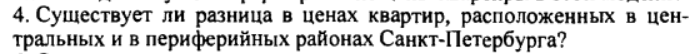

In [ ]:
px.box(df, y='Y', color='X2', template='seaborn', title='<b>Разница в ценах квартир между различными районами')

### По результатам Box plot (см. выше), можно сделать вывод, что разницы в ценнах квартир, расположенных в разных районах - **нет**

image.png

In [ ]:
px.box(df, y='Y', color='X6', template='seaborn', title='<b>Разница в ценах квартир разных типов домов')

### По результатам Box plot (см. выше), можно сделать вывод, что от типа дома цена зависит. (1) - кирпичный, имеет более высокое распределение значения цены в среднем, чем (0) - другой. 

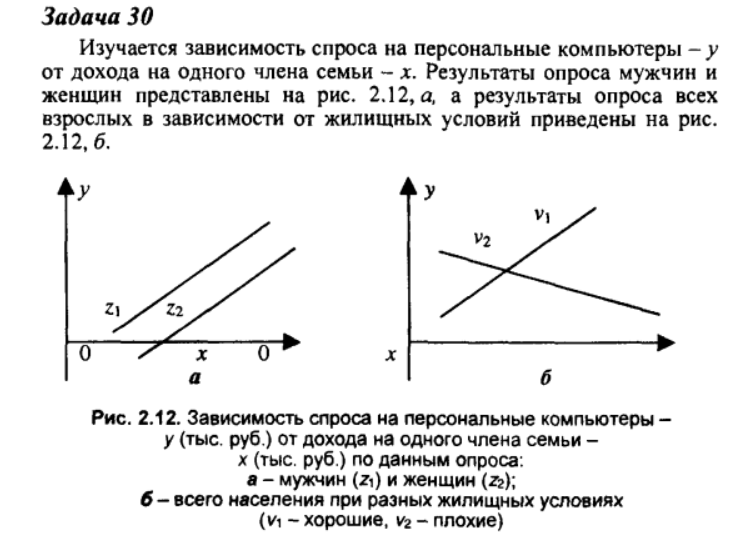

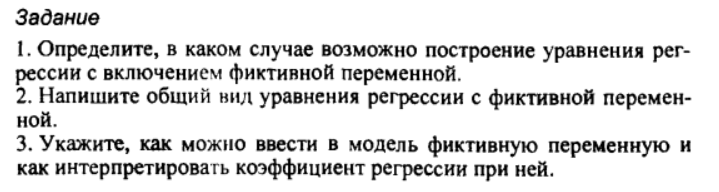

1. Возможно построение уравнения регрессии с включением фиктивной переменной только в 1 случае (из анализа графиков регрессии)
2. Общий вид уравнения: $ M(Y│D)=β_0+β_1 X+ γ_1Z_1 + γ_2Z_2 + ε $

3. Можно ввести фиктивную переменную $ D = ({1 - мужчина, 0 - женщина}) $
<br>Тогда общий вид уравнения будет выглядеть: $ M(Y│D)=β_0+β_1 X+ γD+ ε $ <br>